### 4.4.5. BERT

IMDB 영화평 데이터셋 주소

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

텍스트 토큰화

In [1]:
using Transformers
using Transformers.Basic
using Transformers.Pretrain
using Transformers.BidirectionalEncoder
ENV["DATADEPS_ALWAYS_ACCEPT"] = true # 필요 데이터 자동 다운로드
import Flux

bert_model, wordpiece, tokenizer = pretrain"bert-uncased_L-12_H-768_A-12"
bert_model = bert_model |> Flux.gpu

┌ Info: loading pretrain bert model: uncased_L-12_H-768_A-12.tfbson 
└ @ Transformers.BidirectionalEncoder /home/tyfun/.julia/packages/Transformers/A1N7i/src/bert/load_pretrain.jl:8


TransformerModel{Bert}(
  embed = CompositeEmbedding(tok = Embed(scale=1.0, 768), segment = Embed(scale=1.0, 768), pe = PositionEmbedding(768, max_len=512), postprocessor = Positionwise(LayerNorm(768), Dropout(0.1))),
  transformers = Bert(layers=12, head=12, head_size=64, pwffn_size=3072, size=768),
  classifier = 
    (
      pooler => Dense(768 => 768, tanh)
      masklm => (
        transform => Chain(Dense(768 => 768, gelu), LayerNorm(768))
        output_bias => CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}
      )
      nextsentence => Chain(Dense(768 => 2), logsoftmax)
    )
)

In [2]:
bert_enc = BertTextEncoder(tokenizer, wordpiece; trunc=512)

BertTextEncoder(
├─ TextTokenizer(WordPieceTokenization(bert_uncased_tokenizer, WordPiece(vocab_size=30522, unk=[UNK], max_char=200))),
├─ vocab = Vocab{String, SizedArray}(size = 30522, unk = [UNK], unki = 101),
├─ startsym = [CLS],
├─ endsym = [SEP],
├─ padsym = [PAD],
├─ trunc = 512,
└─ process = Pipelines:
  ╰─ target[tok] := TextEncodeBase.nestedcall(string_getvalue, source)
  ╰─ target[tok] := Transformers.Basic.grouping_sentence(target.tok)
  ╰─ target[tok_segment] := SequenceTemplate{String}([CLS]:<type=1> Input:<type=1> [SEP]:<type=1> (Input:<type=2> [SEP]:<type=2>)<type+=1>...)(target.tok)
  ╰─ target[tok] := TextEncodeBase.nestedcall(first, target.tok_segment)
  ╰─ target[segment] := TextEncodeBase.nestedcall(last, target.tok_segment)
  ╰─ target[trunc_tok] := TextEncodeBase.trunc_and_pad(512, [PAD], tail, tail)(target.tok)
  ╰─ target[trunc_len] := TextEncodeBase.nestedmaxlength(target.trunc_tok)
  ╰─ target[lpad] := false
  ╰─ target[mask] := Transformers.Basic.getmask(tar

특성 추출

In [3]:
using CSV, DataFrames
import MLUtils, FileIO
import TextEncodeBase

function extract_features(bert_enc, bert_model)
    imdb = CSV.read("/home/tyfun/Downloads/IMDB Dataset.csv", DataFrame)
    X = replace.(imdb.review, "<br />" => " ")
    chunk_size = 100
    features = []
    for (i, c) in enumerate(Flux.chunk(X, size=chunk_size))
        i % 10 == 0 && println("$(chunk_size * i) / $(length(X))")
        c = TextEncodeBase.encode(bert_enc, collect(c)) # decode(bertenc, c.input.tok)
        c = c |> Flux.gpu
        x = bert_model.embed(c.input)
        x = bert_model.transformers(x, c.mask)[:,1,:]
        x = MLUtils.unbatch(x) |> Flux.cpu
        features = vcat(features, x)
    end
    X = MLUtils.batch(features)

    y = ifelse.(imdb.sentiment .== "positive", 1, 0);
    y = Flux.onehotbatch(y, 0:1)

    FileIO.save("imdb_bert_feat.jld2", Dict("X" => X, "y" => y))
end

extract_features (generic function with 1 method)

**특성 파일 재생성시에만 아래 코드 언코멘트 (실행 한시간 이상 걸림)**

In [4]:
#extract_features(bert_enc, bert_model)

1000 / 50000


2000 / 50000


3000 / 50000


4000 / 50000


5000 / 50000


6000 / 50000


7000 / 50000


8000 / 50000


9000 / 50000


10000 / 50000


11000 / 50000


12000 / 50000


13000 / 50000


14000 / 50000


15000 / 50000


16000 / 50000


17000 / 50000


18000 / 50000


19000 / 50000


20000 / 50000


21000 / 50000


22000 / 50000


23000 / 50000


24000 / 50000


25000 / 50000


26000 / 50000


27000 / 50000


28000 / 50000


29000 / 50000


30000 / 50000


31000 / 50000


32000 / 50000


33000 / 50000


34000 / 50000


35000 / 50000


36000 / 50000


37000 / 50000


38000 / 50000


39000 / 50000


40000 / 50000


41000 / 50000


42000 / 50000


43000 / 50000


44000 / 50000


45000 / 50000


46000 / 50000


47000 / 50000


48000 / 50000


49000 / 50000


50000 / 50000


In [3]:
import MLUtils, FileIO
function get_data(batchsize = 64)
    dic = FileIO.load("imdb_bert_feat.jld2")
    X, y = dic["X"], dic["y"]
    train, test = MLUtils.splitobs((X, y), at = 0.7);
    train_loader = MLUtils.DataLoader(train, batchsize=batchsize)#, shuffle=true)
    test_loader = MLUtils.DataLoader(test, batchsize=batchsize)
    
    return train_loader, test_loader
end

get_data (generic function with 2 methods)

학습 및 테스트, 실행 함수 (4.2절 함수와 동일)

In [4]:
import Flux, Optimisers, Zygote, Functors
using Formatting: printfmtln
using Random: MersenneTwister

function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m(X), y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model(X), y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        #acc += sum((pred .> 0) .== (y .== 1))
        tot += size(X)[end]
        loss += loss_fn(pred, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

function run_epochs(loaders, model, loss_fn, optimizer, epochs)
    train_loader, test_loader = loaders
    train_losses, accuracies = [], [];
    for t in 1:epochs
        println("Epoch $t")
        println("-------------------------------")
        model, optimizer, losses = 
            train(train_loader, model, loss_fn, optimizer)
        train_losses = vcat(train_losses, losses)
        acc, _ = test(test_loader, model, loss_fn)
        push!(accuracies, acc)
    end
    train_losses, accuracies
end

init(rng) = Flux.glorot_uniform(rng)

init (generic function with 1 method)

분류 모델 정의 및 학습

In [5]:
rng = MersenneTwister(1)
model = Flux.Dense(768 => 2; init=init(rng)) |> Flux.gpu
loss_fn = Flux.Losses.logitcrossentropy
optimizer = Optimisers.setup(Optimisers.Adam(), model);

_, accuracies = run_epochs(get_data(), model, loss_fn, optimizer, 20)

Epoch 1
-------------------------------


[Train] loss: 0

.4591470 [100/547]


[Train] loss: 0.3394720 [200/547]
[Train] loss: 0.3911216 [300/547]
[Train] loss: 0.2921254 [400/547]


[Train] loss: 0.2025667 [500/547]


[Test] Accuracy: 8

5.0, Avg loss: 0.3407898
Epoch 2
-------------------------------
[Train] loss: 0.3922258 [100/547]
[Train] loss: 0.2965676 [200/547]


[Train] loss: 0.3679860 [300/547]
[Train] loss: 0.2639497 [400/547]
[Train] loss: 0.1919520 [500/547]


[Test] Accuracy: 85.6, Avg loss: 0.3263318
Epoch 3
-------------------------------


[Train] loss: 0.3843150 [100/547]


[Train] loss: 0.2934344 [200/547]
[Train] loss: 0.3623374 [300/547]
[Train] loss: 0

.2562045 [400/547]
[Train] loss: 0.1872788 [500/547]


[Test] Accuracy: 86.1, Avg loss: 0.3199521
Epoch 4
-------------------------------
[Train] loss: 0.3788965 [100/547]
[Train] loss: 0.2938748 [200/547]


[Train] loss: 0.3591572 [300/547]


[Train] loss: 0.2541184 [400/547]
[Train] loss: 0.1838290 [500/547]


[Test] Accuracy: 86.3, Avg loss: 0.3162369
Epoch 5
-------------------------------
[Train] loss: 0.3745764 [100/547]


[Train] loss: 0.2947116 [200/547]
[Train] loss: 0.3567808 [300/547]


[Train] loss: 0.2541456 [400/547]
[Train] loss: 0.1811696 [500/547]


[Test] Accuracy: 86.4, Avg loss: 0.3138126
Epoch 6
-------------------------------
[Train] loss: 0.3709810 [100/547]


[Train] loss: 0.2953364 [200/547]
[Train] loss: 0.3548420 [300/547]
[Train] loss: 0.2550472 [400/547]


[Train] loss: 0.1791016 [500/547]


[Test] Accuracy: 86.6, Avg loss: 0.3121171
Epoch 7
-------------------------------
[Train] loss: 0.3678829 [100/547]


[Train] loss: 0.2956858 [200/547]
[Train] loss: 0.3532090 [300/547]
[Train] loss: 0.2563174 [400/547]


[Train] loss: 0.1774816 [500/547]


[Test] Accuracy: 86.7, Avg loss: 0.3108741
Epoch 8
-------------------------------
[Train] loss: 0.3651336 [100/547]


[Train] loss: 0.2958173 [200/547]
[Train] loss: 0.3518093 [300/547]
[Train] loss: 0.2577270 [400/547]


[Train] loss: 0.1762023 [500/547]


[Test] Accuracy: 86.8, Avg loss: 0.3099308
Epoch 9
-------------------------------


[Train] loss: 0.3626388 [100/547]
[Train] loss: 0.2957989 [200/547]
[Train] loss: 0.3505918 [300/547]


[Train] loss: 0.2591646 [400/547]
[Train] loss: 0.1751829 [500/547]


[Test] Accuracy: 86.9, Avg loss: 0.3091975
Epoch 10
-------------------------------


[Train] loss: 0.3603405 [100/547]
[Train] loss: 0.2956837 [200/547]
[Train] loss: 0.3495174 [300/547]


[Train] loss: 0.2605735 [400/547]
[Train] loss: 0.1743622 [500/547]


[Test] Accuracy: 87.0, Avg loss: 0.3086160
Epoch 11
-------------------------------
[Train] loss: 0.3582032 [100/547]


[Train] loss: 0.2955082 [200/547]
[Train] loss: 0.3485558 [300/547]


[Train] loss: 0.2619252 [400/547]
[Train] loss: 0.1736941 [500/547]


[Test] Accuracy: 87.0, Avg loss: 0.3081487
Epoch 12
-------------------------------
[Train] loss: 0.3562049 [100/547]


[Train] loss: 0.2952960 [200/547]
[Train] loss: 0.3476839 [300/547]


[Train] loss: 0.2632058 [400/547]
[Train] loss: 0.1731439 [500/547]


[Test] Accuracy: 87.0, Avg loss: 0.3077686
Epoch 13
-------------------------------
[Train] loss: 0.3543316 [100/547]


[Train] loss: 0.2950622 [200/547]
[Train] loss: 0.3468843 [300/547]


[Train] loss: 0.2644098 [400/547]


[Train] loss: 0.1726855 [500/547]


[Test] Accuracy: 87.0, Avg loss: 0.3074570
Epoch 14
-------------------------------
[Train] loss: 0.3525730 [100/547]
[Train] loss: 0.2948161 [200/547]


[Train] loss: 0.3461438 [300/547]
[Train] loss: 0.2655368 [400/547]
[Train] loss: 0.1722989 [500/547]


[Test] Accuracy: 87.1, Avg loss: 0.3071999
Epoch 15
-------------------------------
[Train] loss: 0.3509218 [100/547]
[Train] loss: 0.2945637 [200/547]


[Train] loss: 0.3454526 [300/547]
[Train] loss: 0.2665884 [400/547]
[Train] loss: 0.1719693 [500/547]


[Test] Accuracy: 87.1, Avg loss: 0.3069864
Epoch 16
-------------------------------
[Train] loss: 0.3493708 [100/547]
[Train] loss: 0.2943086 [200/547]


[Train] loss: 0.3448032 [300/547]
[Train] loss: 0.2675681 [400/547]
[Train] loss: 0.1716850 [500/547]


[Test] Accuracy: 87.1, Avg loss: 0.3068087
Epoch 17
-------------------------------


[Train] loss: 0.3479141 [100/547]
[Train] loss: 0.2940531 [200/547]
[Train] loss: 0.3441900 [300/547]


[Train] loss: 0.2684800 [400/547]
[Train] loss: 0.1714374 [500/547]


[Test] Accuracy: 87.1, Avg loss: 0.3066604
Epoch 18
-------------------------------
[Train] loss: 0.3465459 [100/547]


[Train] loss: 0.2937985 [200/547]
[Train] loss: 0.3436088 [300/547]
[Train] loss: 0.2693288 [400/547]


[Train] loss: 0.1712196 [500/547]
[Test] Accuracy: 87.1, Avg loss: 0.3065367
Epoch 19
-------------------------------


[Train] loss: 0.3452608 [100/547]
[Train] loss: 0.2935457 [200/547]
[Train] loss: 0.3430562 [300/547]


[Train] loss: 0.2701187 [400/547]
[Train] loss: 0.1710262 [500/547]


[Test] Accuracy: 87.1, Avg loss: 0.3064336
Epoch 20
-------------------------------
[Train] loss: 0.3440531 [100/547]


[Train] loss: 0.2932953 [200/547]
[Train] loss: 0.3425295 [300/547]
[Train] loss: 0.2708543 [400/547]


[Train] loss: 0.1708533 [500/547]


[Test] Accuracy: 87.1, Avg loss: 0.3063479


(Any[0.45914698f0, 0.339472f0, 0.39112157f0, 0.29212543f0, 0.20256668f0, 0.39222577f0, 0.29656762f0, 0.36798602f0, 0.2639497f0, 0.19195195f0  …  0.34526074f0, 0.29354566f0, 0.34305614f0, 0.2701187f0, 0.17102624f0, 0.3440531f0, 0.29329526f0, 0.3425295f0, 0.27085426f0, 0.17085326f0], Any[85.03333333333333, 85.61999999999999, 86.06666666666666, 86.26666666666667, 86.44666666666667, 86.64666666666668, 86.72666666666666, 86.83999999999999, 86.89333333333333, 86.95333333333333, 86.96000000000001, 86.98, 87.04666666666667, 87.06, 87.08666666666667, 87.08, 87.12, 87.1, 87.12666666666667, 87.14666666666666])

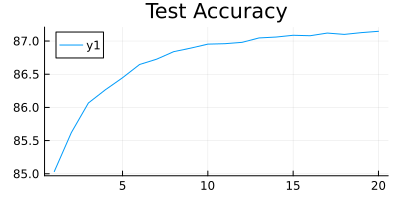

In [6]:
import Plots
Plots.gr(size=(400,200))
title = "Test Accuracy"
Plots.plot(accuracies, title=title)